In [1]:
%pylab inline
from astropy.io import fits as pyfits
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from astropy.io import fits
from astropy.table import Table,Column
import scipy.stats.distributions as dist

import os
import warnings
import requests

mpl.rcParams['text.usetex']=True
mpl.rcParams['axes.linewidth'] = 3

mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18 


warnings.filterwarnings('ignore', category=RuntimeWarning, append=True)
warnings.filterwarnings('ignore', category=UserWarning, append=True)

from PIL import Image
import urllib, cStringIO
from astropy.table import Table



Populating the interactive namespace from numpy and matplotlib


In [2]:
#Hubble Data:
hubble_data = pyfits.open('/home/mel/Documents/GZ_HUBBLE/other_catalogs/ULTRAVISTA/matched_catalog_12_04_15.fits')
hubble_data=hubble_data[1].data
z='Z_BEST_COMBINED'
data_2_1 = (hubble_data[z]>=.2) & (hubble_data[z]<=1) 
print 'The number of galaxies in COSMOS between $0.2 < z < 1.0$ is %s'%len(hubble_data[data_2_1])

#red_sequence = (hubble_data[z]>=0.2) & (hubble_data[z]<=1) & (hubble_data['MNUV']-hubble_data['MR']>(2.7-.077*hubble_data['MR'])) 
#blue_cloud = (hubble_data[z]>=0.2) & (hubble_data[z]<=1) & (hubble_data['MNUV']-hubble_data['MR']<(1.9-.077*hubble_data['MR'])) 

red_sequence = (hubble_data[z]>=0.2) & (hubble_data[z]<=1) & (hubble_data['MNUV']-hubble_data['MR']>3*(hubble_data['MR']-hubble_data['MJ'])+1) & (hubble_data['MNUV']-hubble_data['MR']>3.1) 
blue_cloud = (hubble_data[z]>=0.2) & (hubble_data[z]<=1) & ((hubble_data['MNUV']-hubble_data['MR']<3*(hubble_data['MR']-hubble_data['MJ'])+1) | (hubble_data['MNUV']-hubble_data['MR']<3.1)) 


print 'The number of red galaxies: %s'%len(hubble_data[red_sequence])
print 'The number of blue galaxies: %s'%len(hubble_data[blue_cloud])

The number of galaxies in COSMOS between $0.2 < z < 1.0$ is 52732
The number of red galaxies: 10015
The number of blue galaxies: 42717


In [3]:
p_spiral = 't04_spiral_a01_spiral_weighted_fraction'
p_clumpy = 't12_clumpy_a01_yes_weighted_fraction'
p_merger = 't08_odd_feature_a06_merger_weighted_fraction'
p_irregular= 't08_odd_feature_a04_irregular_weighted_fraction'
p_edgeon= 't02_edgeon_a01_yes_weighted_fraction'
N_spiral = 't04_spiral_total_weight'
N_clumpy = 't12_clumpy_total_weight'
N_odd = 't06_odd_a01_yes_weight'
N_edge = 't02_edgeon_total_weight'

In [60]:
disk_cut = .5
sb_cut=21
p_edge_cut=(hubble_data[p_edgeon]<.6)

SB_cut = (hubble_data['MU_HI']<sb_cut)
red_disks = red_sequence & SB_cut & (hubble_data['t01_smooth_or_features_a02_features_or_disk_best_fraction']>=disk_cut)  & (hubble_data[N_edge]>=5) & p_edge_cut 
blue_disks = blue_cloud & SB_cut & (hubble_data['t01_smooth_or_features_a02_features_or_disk_best_fraction']>=disk_cut)  & (hubble_data[N_edge]>=5) & p_edge_cut
all_disks = SB_cut & (hubble_data['t01_smooth_or_features_a02_features_or_disk_best_fraction']>=disk_cut)  & (hubble_data[N_edge]>=5) & p_edge_cut


In [53]:
def color_color(zl,zh):
    z_cut = (hubble_data[z]>=zl) & (hubble_data[z]<zh)
    colorhist,xedge,yedge = np.histogram2d(hubble_data[all_disks & z_cut]['MR']-hubble_data[all_disks & z_cut]['MJ'],hubble_data[all_disks & z_cut]['MNUV']-hubble_data[all_disks & z_cut]['MR'],bins=(10,10))
    N_disks=np.sum(colorhist)
    colorhist = colorhist/N_disks
    extent=[xedge[0],xedge[-1],yedge[0],yedge[-1]]

    colorhist_contour,xedge_contour,yedge_contour = np.histogram2d(hubble_data[all_disks & z_cut]['MR']-hubble_data[all_disks & z_cut]['MJ'],hubble_data[all_disks & z_cut]['MNUV']-hubble_data[all_disks & z_cut]['MR'],bins=(15,15))
    extent_contour=[xedge_contour[0],xedge_contour[-1],yedge_contour[0],yedge_contour[-1]]
    
    return colorhist, extent, colorhist_contour, extent_contour,N_disks

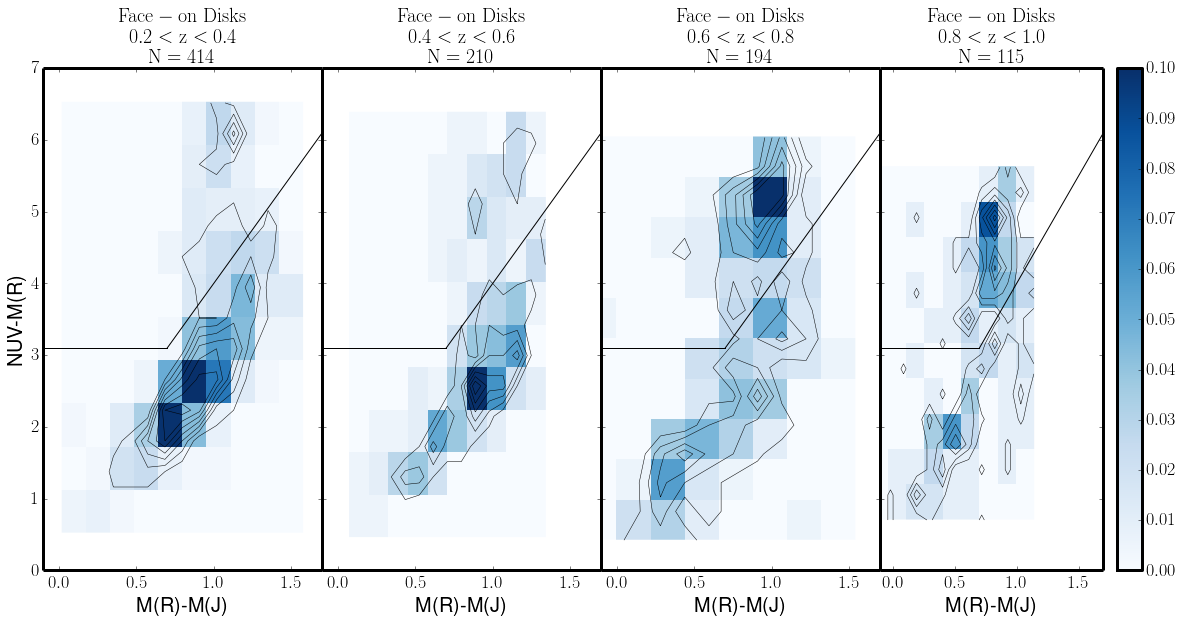

In [62]:
cmap=cm.Blues
alpha=.3

x1=np.linspace(-5,.7,100)
x2=np.linspace(.7,5,100)

vmin=0
vmax=.1

red_list=[.2,.4,.6,.8,1.]

f=plt.figure(figsize=(20,9))
gs=gridspec.GridSpec(1,4)
gs.update(wspace=0)

for i in range(0,4):
    ax=plt.subplot(gs[0,i])

    colorhist, extent, colorhist_contour, extent_contour,N_disks = color_color(red_list[i],red_list[i+1])
    #plt.scatter(hubble_data[all_disks]['MR']-hubble_data[all_disks]['MJ'],hubble_data[all_disks]['MNUV']-hubble_data[all_disks]['MR'],s=.1,alpha=alpha)
    plt.contour(colorhist_contour.T,extent=extent,colors='k',linewidths=.5)
    plt.imshow(colorhist.T,origin='lower',extent=extent,interpolation='nearest',cmap=cmap,aspect='auto',vmin=vmin,vmax=vmax)
    plt.ylim(0,7)
    plt.xlim(-.1,1.7)
    plt.plot(x1,3.1+0*x1,c='k')
    plt.plot(x2,3*x2+1,c='k')
    plt.title('$\mathrm{Face-on~Disks}$\n$\mathrm{%s<z<%s}$\n$\mathrm{N=%s}$'%(red_list[i],red_list[i+1],int(N_disks)),fontsize=20)
    if i==0:
        plt.ylabel('NUV-M(R)',fontsize=20)
    else:
        plt.tick_params(labelleft='off')
    plt.xlabel('M(R)-M(J)',fontsize=20)
   
    if i==3:
        plt.colorbar()
        
plt.savefig('Poster_Images/color_color_vs_redshift.eps',format='eps',dpi=1000)


In [61]:
len(hubble_data[all_disks & (hubble_data[z]>.2) & (hubble_data[z]<.4)])

407

In [19]:
colorhist = colorhist/np.sum(colorhist)

In [20]:
colorhist

array([[ 0.        ,  0.        ,  0.        ,  0.00046707,  0.0032695 ,
         0.        ,  0.00046707,  0.        ,  0.        ,  0.        ,
         0.00046707,  0.        ,  0.        ,  0.        ,  0.00046707],
       [ 0.        ,  0.        ,  0.        ,  0.00046707,  0.00373657,
         0.00280243,  0.00046707,  0.        ,  0.00046707,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.0032695 ,  0.02008407,
         0.04063522,  0.01401214,  0.00140121,  0.00046707,  0.00093414,
         0.00046707,  0.00046707,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.00093414,  0.00607193,
         0.05931808,  0.13311537,  0.04203643,  0.01261093,  0.01027557,
         0.00934143,  0.00513779,  0.00140121,  0.00046707,  0.00046707],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.00046707,
         0.00747314,  0.04297057,  0.16113965, 